In [74]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
from API_service import get_movie_details
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import scipy.sparse as sp
from sklearn.decomposition import PCA
import math


# Autoreload .py files in external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
users_fav_movies = pd.read_csv('data/preprocessed/preprocessed_ratings.csv')
users_fav_movies.head()

users = np.unique(users_fav_movies['userId'])
movie_ids = np.unique(users_fav_movies['movieId'])

total_users = len(users)
total_movies = len(movie_ids)

print("Users: {} and Movies: {}".format(total_users, total_movies))
print(len(movie_ids))

Users: 265072 and Movies: 32028
32028


# Helper methods

In [13]:
count_vect = CountVectorizer()

# Return list of (mapped) ids for user 
def get_movies_for_user(id):
    # Get all rating entries that have matching ID
    entries = users_fav_movies[users_fav_movies['userId'] == id].copy()
    # Create np.array of all unique IDs of those ratings
    movieId_map = np.array(entries['uniqueId'], dtype=np.int32)
    return movieId_map

# Returns one-hot (unique) ids of movies to their original movieIds
def get_original_movieIds(uniqueIds):
    result = []
    for id in uniqueIds:
        result.append(movie_ids[id])
    return result

# Get the one-hot vector of liked movies for user
# input param should be list of unique IDs (not movieIds)
def get_vector(movie_list_of_user):
    vector = np.zeros(total_movies)
    vector[movie_list_of_user] = 1
    return vector

# save dataframe as sparse matrix
def save_as_sparse(df, path):
    sparse_matrix = sp.csr_matrix(df.values)
    sp.save_npz(path, sparse_matrix)

# loads sparse matrix and converts it to dataframe
def load_sparse(path):
    sparse_matrix = sp.load_npz(path)
    return sparse_matrix

# Gets one-hot ID of a movie, the way we do this is 
# by assigning it its index in the list of all unique movies
def get_unique_movie_id(x):
    index = np.where(movie_ids == x)
    return index[0][0]

# Load sparse matrix as dataframe
def load_sparse_as_df(path):
    sparse_matrix = sp.load_npz(path)
    df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
    return df

# Filter out a large set of users that have too few or too little ratings. 

In this step, we aim to cut off users that have either rated too many or too few movies. This way, we are left with a dataset that is reduced in size and that has no big outliers. This is fine for this proof of concept.

In [4]:
# Create dataframe that holds the one-hot vectors
range_of_num = np.arange(0, total_movies)
count_df = pd.DataFrame(columns=range_of_num)

# Filter users if they have very few ratings to 
# Returns a list of ID - Rating amounts (e.g. [ID: 26 - Rating count: 3669])
rating_counts = users_fav_movies['userId'].value_counts()

avg_rating_amt = round(rating_counts.mean()) # 10 - 100 (open) or 34-64 (strict)
lower_trehshold = 34
upper_treshold = 64

filtered_users = rating_counts[(rating_counts > lower_trehshold) & (rating_counts < upper_treshold)].index.tolist()
print("Average rated movies count: {}".format(avg_rating_amt))
print("Users before filtering: {}, users after filtering: {}".format(total_users, len(filtered_users)))

Average rated movies count: 49
Users before filtering: 265072, users after filtering: 34116


# Create sparse one-hot matrix of user ratings

Transform each rating of user to a binary categorical matrix. 

In [ ]:
def get_one_hot_frame(users):
    vectors = np.zeros((len(users), total_movies), dtype=np.int16)
    for i in range(0, len(users)):
        user = users[i]  
        user_movies = get_movies_for_user(user) # Get all liked movies of user
        vector = get_vector(user_movies) # Get binary vector of liked movies
        vectors[i] = vector # Add vector to dataframe
    df = pd.DataFrame(vectors)
    return df
 
# Save the one-hot encoded users as a sparse matrix
onehot_frame = get_one_hot_frame(filtered_users)
save_as_sparse(onehot_frame, "data/processed/sparse_binary_ratings.npz")
print(onehot_frame.shape)

We are left with a sparse binary matrix that contains binary preferences of each user.

In [476]:
onehot_frame = load_sparse("data/processed/sparse_binary_ratings.npz") # Load as sparse matrix for clustering
dense = onehot_frame.toarray() # Transform to np array
dense_frame = pd.DataFrame(dense)
dense_frame_sample = dense_frame.sample(1000)
dense_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32018,32019,32020,32021,32022,32023,32024,32025,32026,32027
0,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dimensionality reduction

We perform NMF on this dataset to reduce its dimensions. This is a more appropriate approach than PCA because of the categorical (binary) nature of the matrix.

In [485]:

n_components = 3
nmf = NMF(n_components=n_components, init='random', random_state=0)
nmf.fit(onehot_frame)

# Get the basis matrix (W)
W = nmf.components_
H = nmf.transform(onehot_frame)

print(H.shape)

(34116, 3)


# Perform clustering

With the data dimensions reduced, we can now apply K-means to the reduced user preference matrix. We chose the number of clusters by experimentation (silhouette & inertia measures). Each cluster represents a group of people with similar interests. The goal of clustering is to speed up the search for similar users later on by assigning a new user to a cluster before finding most similar users, essentially reducing the search space.

In [486]:
cluster_amt = 5

km = KMeans(n_clusters=cluster_amt, n_init='auto', init='random', random_state=52)
km.fit(H)
labels = km.labels_
centres = km.cluster_centers_

# Save labels and clusters to CSV
np.savetxt("data/output/labels.csv", labels, delimiter=",")
np.savetxt("data/output/centres.csv", centres, delimiter=",")


label_counts = Counter(labels)
sorted_labels = label_counts.most_common()

# Print label distributions
print(sorted_labels)

[(2, 11423), (4, 9063), (3, 5838), (0, 4264), (1, 3528)]


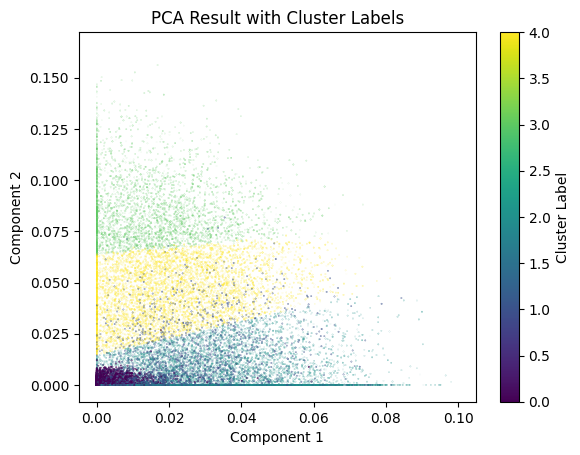

[(2.0, 11423), (4.0, 9063), (3.0, 5838), (0.0, 4264), (1.0, 3528)]


In [499]:
# Create a scatter plot of the results
plt.scatter(H[:, 0], H[:, 1], H[:, 2], c=labels, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Result with Cluster Labels')
plt.colorbar(label='Cluster Label')
plt.show()

label_counts = Counter(labels)
sorted_labels = label_counts.most_common()

# Print label distributions
print(sorted_labels)

# Load clustering results from previous step

Then assign respective labels to each user for use later. 

In [500]:
# load the labels and centres 
labels = np.loadtxt("data/output/labels.csv", delimiter=",")
centres = np.loadtxt("data/output/centres.csv", delimiter=",")

pca_frame = pd.DataFrame(H)
pca_frame['cluster'] = labels # Append labels column to PCA frame

Some helper methods that will assist our recommendation engine later

In [489]:
# Returns movie details using the TMDB API
def fetch_movie_detail(ids):
    titles = []
    genres = []
    for id in ids:
        detail = get_movie_details(id)
        titles.append(detail.title)
        genres.append(detail.genre_names[:2])
    return titles, genres

# Returns cluster closest to user vector
def get_closest_cluster(user):
    distances = euclidean_distances([user], centres).ravel()
    ascending_distances = sorted(enumerate(distances), key=lambda x: x[1])
    print("* Cluster dist. (ascending) for user: ", ascending_distances)
    return ascending_distances[0][0]

# Gets original user ID instead of
# its assigned one in the binary matrix
def get_original_user_id(x):
    id = filtered_users[x]
    return id

# Use euclidean distance metric to sort users
# close to a specified point (cluster centre or other user)
# and return the top n users in ascending order
def get_users_close_to(point, users, n_users):
    distances = euclidean_distances(point, users).ravel()
    ascending_distances = sorted(enumerate(distances), key=lambda x: x[1])
    closest_users = ascending_distances[1:n_users+1]  # get n most similar users in cluster
    closest_users = [user[0] for user in closest_users]  # Get indices
    unique_ids = [get_original_user_id(num) for num in closest_users]
    
    # print("* 5 Closest users: ", closest_users[:5])
    return unique_ids

# This method receives a list of movieIds and
# optionally a list of genre filters, then it
# retrieves names and genres for each movie and
# prints these results as a list
def print_movie_output(movies, active_genres=[], max_print=50):
    print("Movie output: \n")
    recoms = []
    titles, genres = fetch_movie_detail(movies)
    zipped = zip(titles, genres)

    if(len(active_genres) > 0):
        for title, genre in zipped:
            if(genre[0] in active_genres):
                recoms.append(title)
                print(title, genre)
            elif(len(genre) > 1 and genre[1] in active_genres):
                recoms.append(title)
                print(title, genre)
    else:
        recoms = list(zipped)
        flat_genres = [item for sublist in genres for item in sublist]
        counter = Counter(flat_genres)
        most_common = counter.most_common(5)
        print("Genre distribution of movies:", most_common)
        print("Movies:")
        for title in titles[:max_print]:
            print("- ", title)

# Inspecting each cluster by counting top movies

Here, we inspect each cluster's most commonly liked movies by sampling n users, either randomly or by how close they are to the cluster centre. We then print the most commonly liked movies and their corresponding genres to get an idea of the kind of user that each cluster contains. The 'drama' genre is by far the most popular in the dataset and usually first place, so we print a top-n genres. The clusters are by no means perfect (users can like many different movies, share account with others, etc), but provide a strong heuristic in our search.

1. Find all users in particular cluster
2. Sample users from step 1 by cluster centre similarity or randomly
3. Append all liked movies to a temporary list
4. Apply counter to list and return the top-n most-liked movies

The 'pop_score' hyperparameter essentially skips the first 10x n results to prevent assessing the clusters based on overly popular movies (e.g. LOTR, The Shawkshank Redemption, etc)

In [525]:
def get_cluster_favourites(cluster, pop_score=2, movie_amt=40, sample_method='similarity'):
    n_movies = movie_amt
    n_users = 50

    # Bounds of results. Range of [10, 20] will skip the first 10 
    # final recommended results (perhaps too popular/well-liked)
    lower_range = 10 * pop_score 
    upper_range = lower_range + movie_amt

    # Get descending scores for similarity to cluster centre
    users_in_clus = pca_frame[pca_frame['cluster'] == cluster].copy()
    users_in_clus.drop('cluster', axis=1, inplace=True) # Drop cluster col
    
    # Sample users by cosine similarity 
    if(sample_method == 'similarity'):
        unique_ids = get_users_close_to([centres[cluster]], users_in_clus, n_users)

    # Randomly sample n users
    elif(sample_method == 'random'):
        sampled_users = users_in_clus.sample(n=n_users)
        ids = list(sampled_users.index.values)
        unique_ids = [get_original_user_id(num) for num in ids]
    fav_movies = []     

    # For the n selected users, get their fav movie IDs
    for user_id in unique_ids:
        movie_ids = get_movies_for_user(user_id)
        movie_ids_orig = get_original_movieIds(movie_ids)
        fav_movies.extend(movie_ids_orig)

    # Count top-n most occuring movies among n users
    counter = Counter(fav_movies)
    most_common = counter.most_common(upper_range) # Sort movie ID counts by descending
    common_ids = [id[0] for id in most_common] # Transfer count tuple to just movie ID
    return common_ids[lower_range:upper_range]

In [ ]:
# For each cluster centre, sample and print results.
for i in range(0, len(centres)):
    print("Cluster favourites: ", i, "\n")
    a = get_cluster_favourites(i, sample_method='random')
    print_movie_output(a, max_print=5)

# Testing the recommendation engine. 

This method returns commonly liked movies from users that are similar to the user that we want to recommend movies to.

In [446]:
def get_cluster_recommendations(cluster, user_vec, pop_score=1, movie_amt = 60, sample_method='similarity'):
    n_movies = movie_amt
    n_users = 18 # On how many users the recommendations are based
    
    # Bounds of results. Range of [10, 20] will skip the first 10 
    # final recommended results (perhaps too popular/well-liked)
    lower_range = 10*pop_score
    upper_range = lower_range + movie_amt
    print("* Searching between ", lower_range, " and ", upper_range)

    # Get descending scores for similarity to cluster centre
    users_in_clus = pca_frame[pca_frame['cluster'] == cluster].copy()
    users_in_clus.drop('cluster', axis=1, inplace=True) # Drop cluster col

    # Sample users by cosine similarity 
    if(sample_method == 'similarity'):
        unique_ids = get_users_close_to(user_vec, users_in_clus, n_users)

    # Randomly sample n users
    elif(sample_method == 'random'):
        print(users_in_clus.shape)
        sampled_users = users_in_clus.sample(n=n_users)
        ids = list(sampled_users.index.values)
        unique_ids = [get_original_user_id(num) for num in ids]
    fav_movies = []     

    # For the n selected users, get their fav movie IDs
    for user_id in unique_ids:
        movie_ids = get_movies_for_user(user_id)
        movie_ids_orig = get_original_movieIds(movie_ids)
        fav_movies.extend(movie_ids_orig)

    # Count top-n most occuring movies among n users
    counter = Counter(fav_movies)
    most_common = counter.most_common(upper_range) # Sort movie ID counts by descending
    common_ids = [id[0] for id in most_common] # Transfer count tuple to just movie ID
    return common_ids[lower_range:upper_range]

At last, we can give the recommendation engine a spin. We start out with a random user from the dataset, obtain their vector and also debug their currently liked movies. This will give us an idea of what our chosen test user likes. We then serve (unfiltered) recommendations based on preferences of similar users. 

In [514]:
# Get random user from the matrix
unique_id = 5955
user_vec = H[unique_id]
orig_user_id = get_original_user_id(unique_id)  

# Obtain movies liked by this user
user_movie_ids = get_movies_for_user(orig_user_id) 
orig_mov_ids = get_original_movieIds(user_movie_ids)

# Print results
print("User", unique_id, "likes movies: ")
orig_mov_names = print_movie_output(orig_mov_ids, max_print=100)

User 5955 likes movies: 
Movie output: 

Genre distribution of movies: [('Fantasy', 22), ('Adventure', 19), ('Drama', 17), ('Comedy', 13), ('Action', 11)]
Movies:
-  The Shawshank Redemption
-  While You Were Sleeping
-  Liar Liar
-  The Fifth Element
-  The Devil's Advocate
-  City of Angels
-  Edward Scissorhands
-  Pleasantville
-  The Matrix
-  Fight Club
-  Billy Elliot
-  The Emperor's New Groove
-  Monsters, Inc.
-  The Lord of the Rings: The Fellowship of the Ring
-  Harry Potter and the Chamber of Secrets
-  The Lord of the Rings: The Two Towers
-  Big Fish
-  The Lord of the Rings: The Return of the King
-  Harry Potter and the Prisoner of Azkaban
-  I, Robot
-  Charlie and the Chocolate Factory
-  Constantine
-  Sin City
-  Madagascar
-  Corpse Bride
-  Harry Potter and the Goblet of Fire
-  Ice Age: The Meltdown
-  The Devil Wears Prada
-  Pirates of the Caribbean: Dead Man's Chest
-  The Pursuit of Happyness
-  The Illusionist
-  The Prestige
-  The Holiday
-  300
-  Pirat

Next, we calculate the closest cluster to that user, sample users from it and find a set of movies that is well-liked by most of these users. This is still a very broad set and will need filtering to recommend more specifics.

In [519]:
cluster = get_closest_cluster(user_vec)
print("* User assigned to cluster:", cluster)

recom_user = get_cluster_recommendations(cluster, [user_vec], pop_score=0, movie_amt=100, sample_method='similarity')
print_movie_output(recom_user, active_genres=[], max_print=5) # Print non-filtered results (e.g. all movies)

* Cluster dist. (ascending) for user:  [(3, 0.015543546327649062), (4, 0.05049406619487354), (2, 0.09144596259551566), (1, 0.10977728019639575), (0, 0.17049615119974929)]
* User assigned to cluster: 3
* Searching between  0  and  100
Movie output: 

Genre distribution of movies: [('Drama', 42), ('Action', 27), ('Adventure', 23), ('Crime', 19), ('Comedy', 15)]
Movies:
-  Pulp Fiction
-  The Lord of the Rings: The Fellowship of the Ring
-  Star Wars
-  The Shawshank Redemption
-  Schindler's List


# Results

Here are some of the recommendations that would be presented to this user, based on that user's movie preference, sorted by genre. Many of these particular movies also appear in that user's preference list, so we can conclude that predictions for this user are OK! Needless to say, perfect recommendations are not possible given how many different movies a certain user can like, but as we can see, the results are not too far off the mark.

In [516]:
print_movie_output(recom_user, active_genres=['Animation']) # Print genre-based results 

Movie output: 

Toy Story ['Animation', 'Adventure']
WALL·E ['Animation', 'Family']
Monsters, Inc. ['Animation', 'Comedy']
Finding Nemo ['Animation', 'Family']
The Lion King ['Family', 'Animation']
Aladdin ['Animation', 'Family']


In [520]:
print_movie_output(recom_user, active_genres=['Fantasy']) # Print genre-based results 

Movie output: 

The Lord of the Rings: The Fellowship of the Ring ['Adventure', 'Fantasy']
The Lord of the Rings: The Return of the King ['Adventure', 'Fantasy']
The Lord of the Rings: The Two Towers ['Adventure', 'Fantasy']
Harry Potter and the Deathly Hallows: Part 2 ['Fantasy', 'Adventure']
Babe ['Fantasy', 'Drama']
Harry Potter and the Chamber of Secrets ['Adventure', 'Fantasy']
The Green Mile ['Fantasy', 'Drama']
The Hobbit: An Unexpected Journey ['Adventure', 'Fantasy']


In [518]:
print_movie_output(recom_user, active_genres=['Drama']) # Print genre-based results 

Movie output: 

Braveheart ['Action', 'Drama']
Forrest Gump ['Comedy', 'Drama']
The Godfather Part II ['Drama', 'Crime']
Fight Club ['Drama', 'Thriller']
Blade Runner ['Science Fiction', 'Drama']
American Beauty ['Drama']
Eternal Sunshine of the Spotless Mind ['Science Fiction', 'Drama']
Gladiator ['Action', 'Drama']
Fargo ['Crime', 'Drama']
One Flew Over the Cuckoo's Nest ['Drama']
Saving Private Ryan ['Drama', 'History']
Apocalypse Now ['Drama', 'War']
Life Is Beautiful ['Comedy', 'Drama']
American History X ['Drama']
City of God ['Drama', 'Crime']
The Departed ['Drama', 'Thriller']
The Intouchables ['Drama', 'Comedy']
Léon: The Professional ['Crime', 'Drama']
Requiem for a Dream ['Crime', 'Drama']
Babe ['Fantasy', 'Drama']
Four Weddings and a Funeral ['Comedy', 'Drama']
Dead Man Walking ['Drama']
Das Boot ['Drama', 'History']
Run Lola Run ['Action', 'Drama']
Philadelphia ['Drama']
Quiz Show ['History', 'Drama']
In the Line of Fire ['Action', 'Drama']
In the Name of the Father ['Dram